# Lane Navigation Training
for self driving car

In [1]:
# config

OUTPUT_DIR = 'lane_nav_output'
DATASET_DIR = 'lane_nav_data'

In [2]:
# imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import cv2

import os

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# make output directory if needed
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Matplotlib is building the font cache; this may take a moment.


tensorflow version: 2.16.2
keras version: 3.9.0


In [4]:
# The model
def lane_nav_model():
    model = keras.Sequential(name='lane_nav_model')

    # Input
    model.add(keras.layers.Input(shape=(200, 66, 1), batch_size=32))
    
    # Depthwise Separable Convolution for efficiency
    model.add(keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), depth_multiplier=1, padding='same'))
    model.add(keras.layers.Conv2D(24, (1, 1), activation=None))  # Pointwise Conv
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), depth_multiplier=1, padding='same'))
    model.add(keras.layers.Conv2D(36, (1, 1), activation=None))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), depth_multiplier=1, padding='same'))
    model.add(keras.layers.Conv2D(48, (1, 1), activation=None))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), depth_multiplier=1, padding='same'))
    model.add(keras.layers.Conv2D(64, (1, 1), activation=None))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Dropout(0.2))  # Regularization
    
    model.add(keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), depth_multiplier=1, padding='same'))
    model.add(keras.layers.Conv2D(64, (1, 1), activation=None))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1))  # Steering angle output
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [5]:
model = lane_nav_model()
model.summary()

2025-03-09 17:35:47.807944: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-03-09 17:35:47.807993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-09 17:35:47.807998: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-09 17:35:47.808050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-09 17:35:47.808065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "lane_nav_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d                │ (32, 100, 33, 1)       │            10 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 100, 33, 24)      │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (32, 100, 33, 24)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (32, 50, 17, 24)       │           240 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 50, 17, 36)       │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (32, 50, 17, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (32, 25, 9, 36)        │           360 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 25, 9, 48)        │         1,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (32, 25, 9, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (32, 25, 9, 48)        │           480 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 25, 9, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (32, 25, 9, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 25, 9, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (32, 25, 9, 64)        │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 25, 9, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (32, 25, 9, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 14400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 14400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 100)              │     1,440,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 50)               │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 10)               │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 1)                │            11 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,457,421 (5.56 MB)

 Trainable params: 1,457,421 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

Found 43966 dataset files
Image shape: (66, 200, 3)


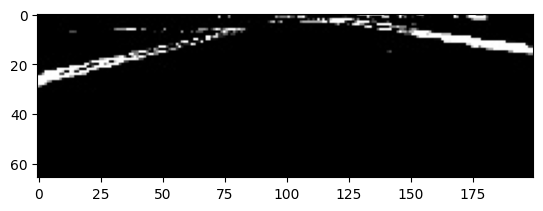

In [6]:
# Load dataset
dataset_files = os.listdir(DATASET_DIR)
dataset_files = [f for f in dataset_files if f.endswith('.jpg')]

# Shuffle dataset
np.random.shuffle(dataset_files)

print(f"Found {len(dataset_files)} dataset files")

index = np.random.randint(0, len(dataset_files))
img = cv2.imread(os.path.join(DATASET_DIR, dataset_files[index]))

print(f"Image shape: {img.shape}")

plt.imshow(img)
plt.show()

In [9]:
def data_generator():
    for f in dataset_files:
        img = cv2.imread(os.path.join(DATASET_DIR, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255.0
        try:
            angle = int(f.split('_')[1])
        except:
            angle = int(f.split('_')[2])
        yield img, angle
    for f in dataset_files:
        img = cv2.imread(os.path.join(DATASET_DIR, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255.0
        try:
            angle = int(f.split('_')[1])
        except:
            angle = int(f.split('_')[2])
        yield np.fliplr(img), 180 - angle

In [10]:
# make dataset

X_data = []
y_data = []

for img, angle in data_generator():
    X_data.append(img)
    y_data.append(angle)

# split
split = int(len(X_data) * 0.8)

X_train = np.array(X_data[:split])
y_train = np.array(y_data[:split])

X_val = np.array(X_data[split:])
y_val = np.array(y_data[split:])

In [11]:
# Train
model = lane_nav_model()

# checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(OUTPUT_DIR, 'lane_nav_model.keras'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

# Save model
model.save(os.path.join(OUTPUT_DIR, 'lane_nav_model_final.h5'))

Epoch 1/30


2025-03-09 17:37:44.088162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 130/2199 ━━━━━━━━━━━━━━━━━━━━ 2:50 83ms/step - loss: 4151.1338

KeyboardInterrupt: 

In [10]:
history.history

{'loss': [1316.0379638671875,
  242.58389282226562,
  168.5070343017578,
  130.7520294189453,
  109.44625091552734,
  98.61239624023438,
  90.34599304199219,
  81.91691589355469,
  76.78858947753906,
  72.82220458984375,
  67.74337005615234,
  65.89797973632812,
  64.04869079589844,
  61.55982971191406,
  63.04487991333008,
  57.2180061340332,
  54.72453308105469,
  55.19880294799805,
  52.03703308105469,
  49.259029388427734,
  49.26205062866211,
  45.86146926879883,
  47.962623596191406,
  44.8052978515625,
  43.53188705444336,
  41.890811920166016,
  41.232730865478516,
  39.77364730834961,
  40.157196044921875,
  39.37498092651367],
 'val_loss': [362.5108642578125,
  277.8537902832031,
  178.01416015625,
  127.40023040771484,
  113.8601303100586,
  105.44927215576172,
  93.32527923583984,
  83.8646469116211,
  82.62461853027344,
  74.95856475830078,
  74.69166564941406,
  74.6464614868164,
  71.5540542602539,
  76.43634796142578,
  64.6173324584961,
  75.52874755859375,
  60.178421

Text(0.5, 0, 'Epoch')

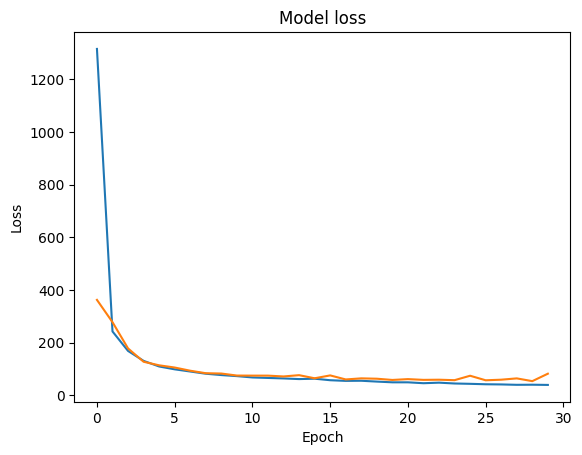

In [11]:
# plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')


In [12]:
model.save(os.path.join(OUTPUT_DIR, 'lane_nav_model_final.keras'))